In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stat
from scipy.special import rel_entr

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import time

import seaborn as sns
import matplotlib.pyplot as plt

!pip install ucimlrepo #https://archive.ics.uci.edu/

#Wine quality dataset

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [ ]:
#url = "https://archive.ics.uci.edu/static/public/186/data.csv"
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep =";")
data

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6  

[1599 rows x 12 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

In [ ]:
data.quality.value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

<BarContainer object of 6 artists>

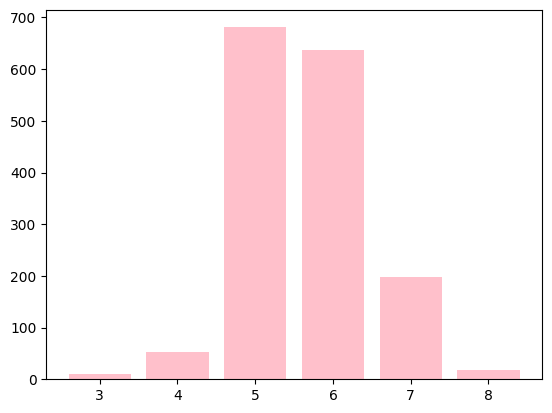

In [ ]:
plt.bar(data.quality.value_counts().keys(),data.quality.value_counts(),color = "pink") #histogram indicates data imbalance

In [ ]:
for i in data.columns:
  len(data[i].drop_duplicates())
  print(f" {i} has {len(np.unique(data[i]))}  unique values")

 fixed acidity has 96  unique values
 volatile acidity has 143  unique values
 citric acid has 80  unique values
 residual sugar has 91  unique values
 chlorides has 153  unique values
 free sulfur dioxide has 60  unique values
 total sulfur dioxide has 144  unique values
 density has 436  unique values
 pH has 89  unique values
 sulphates has 96  unique values
 alcohol has 65  unique values
 quality has 6  unique values


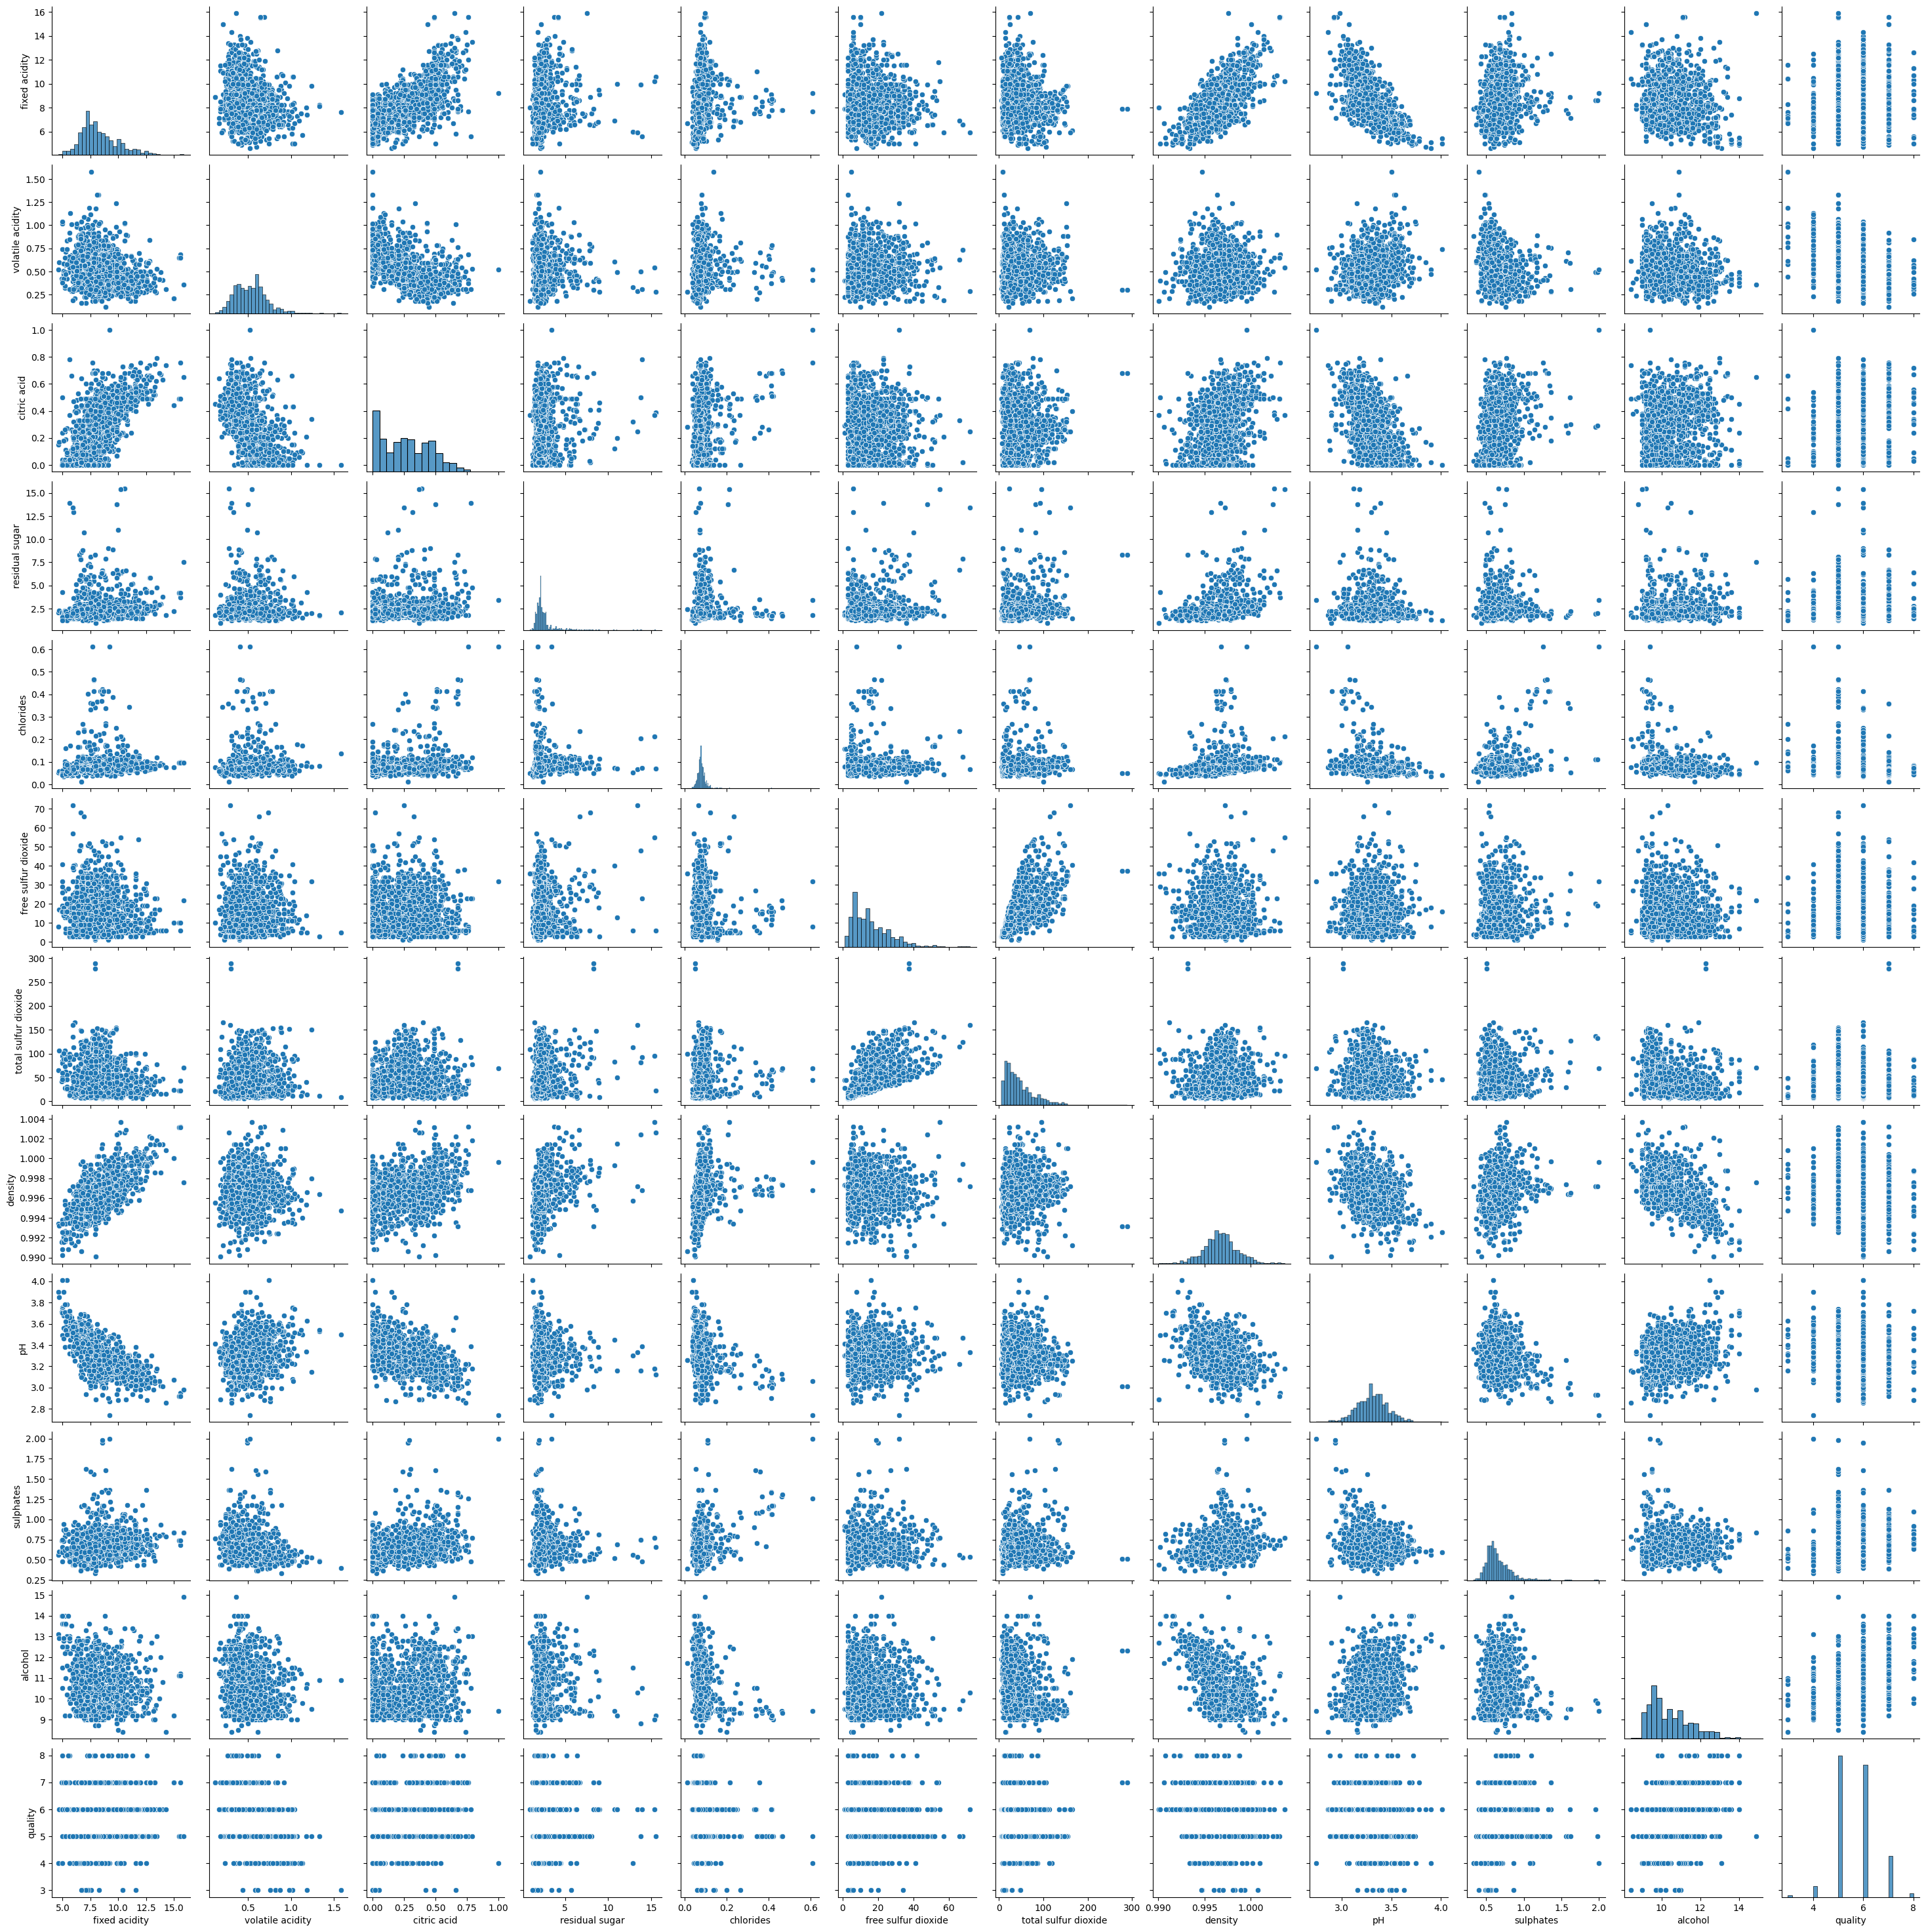

In [ ]:
sns.pairplot(data)

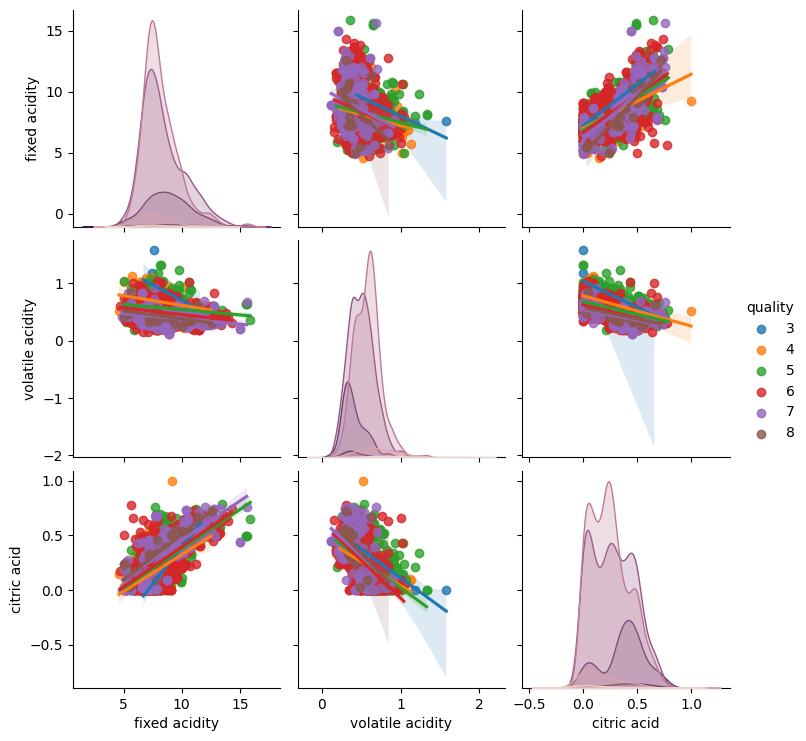

In [ ]:
columns = ["fixed acidity","volatile acidity","citric acid","quality"]
sns.pairplot(data[columns],kind = "reg", hue = "quality")

/tmp/ipython-input-2451574438.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)


[Text(0, 0, 'fixed acidity'),
 Text(1, 0, 'volatile acidity'),
 Text(2, 0, 'citric acid'),
 Text(3, 0, 'residual sugar'),
 Text(4, 0, 'chlorides'),
 Text(5, 0, 'free sulfur dioxide'),
 Text(6, 0, 'total sulfur dioxide'),
 Text(7, 0, 'density'),
 Text(8, 0, 'pH'),
 Text(9, 0, 'sulphates'),
 Text(10, 0, 'alcohol'),
 Text(11, 0, 'quality')]

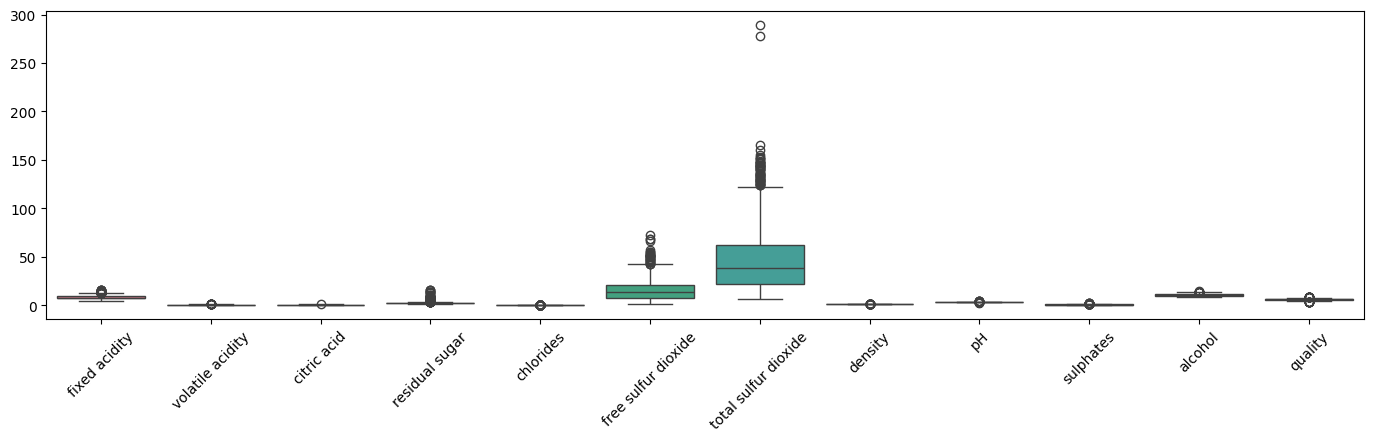

In [ ]:
fig,ax = plt.subplots(1,figsize = (17,4))
ax = sns.boxplot(data = data)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [ ]:
data[data["total sulfur dioxide"]>200] #outliers

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1079            7.9               0.3         0.68             8.3       0.05   
1081            7.9               0.3         0.68             8.3       0.05   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1079                 37.5                 278.0  0.99316  3.01       0.51   
1081                 37.5                 289.0  0.99316  3.01       0.51   

      alcohol  quality  
1079     12.3        7  
1081     12.3        7

In [ ]:
data = data[data["total sulfur dioxide"]<200] #removing outliers
data.shape

(1597, 12)

/tmp/ipython-input-2451574438.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)


[Text(0, 0, 'fixed acidity'),
 Text(1, 0, 'volatile acidity'),
 Text(2, 0, 'citric acid'),
 Text(3, 0, 'residual sugar'),
 Text(4, 0, 'chlorides'),
 Text(5, 0, 'free sulfur dioxide'),
 Text(6, 0, 'total sulfur dioxide'),
 Text(7, 0, 'density'),
 Text(8, 0, 'pH'),
 Text(9, 0, 'sulphates'),
 Text(10, 0, 'alcohol'),
 Text(11, 0, 'quality')]

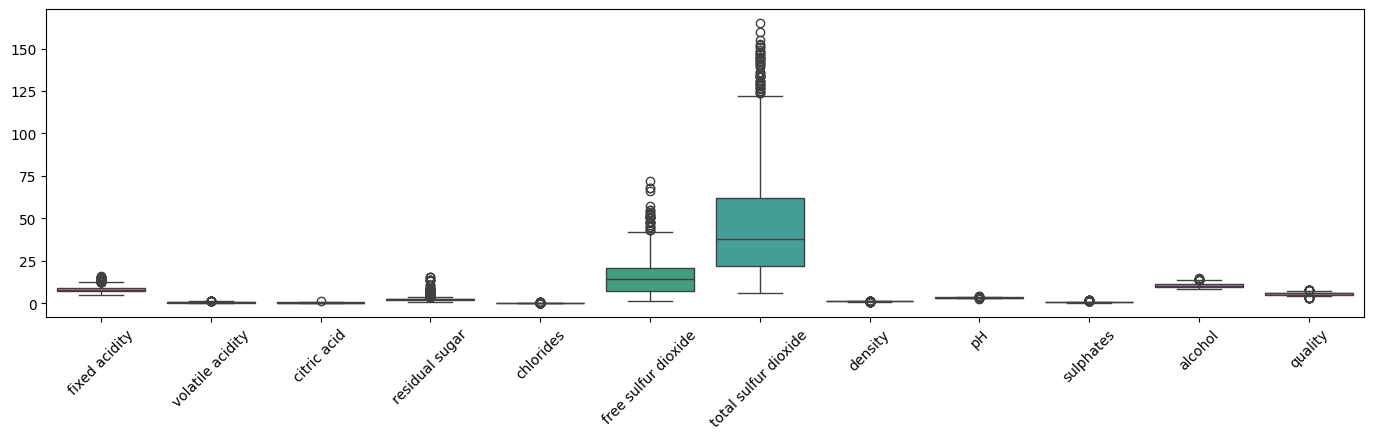

In [ ]:
fig,ax = plt.subplots(1,figsize = (17,4))
ax = sns.boxplot(data = data)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [ ]:
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [ ]:
data_std = pd.DataFrame()
for i in data.columns:
  if i != "quality":
    data_std[i] = (data[i] - np.mean(data[i]))/np.std(data[i],ddof = 1)
  else:
    data_std[i] = data[i]

#np.std(data[i],ddof = 1) = The divisor used is N - 1.
#This calculates the sample standard deviation, which is an unbiased estimator of the population standard deviation for a sample of data.

In [ ]:
data_std.describe()

fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.597000e+03      1.597000e+03  1.597000e+03    1.597000e+03   
mean    7.118775e-17      1.201293e-16  5.339081e-17   -7.118775e-17   
std     1.000000e+00      1.000000e+00  1.000000e+00    1.000000e+00   
min    -2.135419e+00     -2.280048e+00 -1.391387e+00   -1.168783e+00   
25%    -7.003882e-01     -7.715838e-01 -9.283861e-01   -4.524372e-01   
50%    -2.411785e-01     -4.528645e-02 -5.382836e-02   -2.375335e-01   
75%     5.050372e-01      6.251419e-01  7.692848e-01    4.900487e-02   
max     4.350918e+00      5.876831e+00  3.753070e+00    9.289866e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.597000e+03         1.597000e+03          1.597000e+03  1.597000e+03   
mean  -1.512740e-16         1.779694e-17         -7.118775e-17 -8.350323e-14   
std    1.000000e+00         1.000000e+00          1.000000e+00  1.000000e+00   
min   -1.604073e+00        -1.422392e+00         -1.262186e+00 -3.545821e+00   
25%   -3.720247e-01        -8.476045e-01         -7.594598e-01 -6.109478e-01   
50%   -1.808448e-01        -1.770192e-01         -2.567340e-01 -6.214425e-04   
75%    5.281955e-02         4.935662e-01          4.973546e-01  5.778618e-01   
max    1.112001e+01         5.379259e+00          3.733652e+00  3.682565e+00   

                 pH     sulphates       alcohol      quality  
count  1.597000e+03  1.597000e+03  1.597000e+03  1597.000000  
mean   2.847510e-16  1.067816e-16 -6.050959e-16     5.634314  
std    1.000000e+00  1.000000e+00  1.000000e+00     0.806630  
min   -3.708218e+00 -1.936711e+00 -1.898626e+00     3.000000  
25%   -6.585382e-01 -6.390204e-01 -8.650444e-01     5.000000  
50%   -9.670044e-03 -2.261189e-01 -2.073106e-01     6.000000  
75%    5.743113e-01  4.227263e-01  6.383472e-01     6.000000  
max    4.532407e+00  7.913939e+00  4.208902e+00     8.000000

/tmp/ipython-input-752472295.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)


[Text(0, 0, 'fixed acidity'),
 Text(1, 0, 'volatile acidity'),
 Text(2, 0, 'citric acid'),
 Text(3, 0, 'residual sugar'),
 Text(4, 0, 'chlorides'),
 Text(5, 0, 'free sulfur dioxide'),
 Text(6, 0, 'total sulfur dioxide'),
 Text(7, 0, 'density'),
 Text(8, 0, 'pH'),
 Text(9, 0, 'sulphates'),
 Text(10, 0, 'alcohol'),
 Text(11, 0, 'quality')]

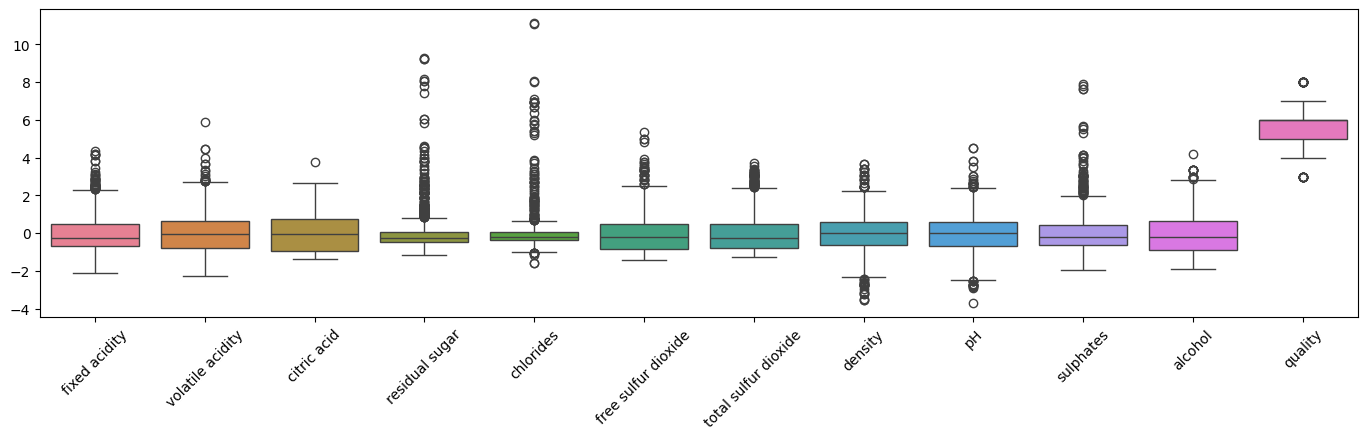

In [ ]:
fig,ax = plt.subplots(1,figsize = (17,4))
sns.boxplot(data_std)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [ ]:
data_std["boolQuality"] = np.where(data_std["quality"]>5,1,0)
data_std[["quality","boolQuality",]].value_counts()

quality  boolQuality
5        0              681
6        1              638
7        1              197
4        0               53
8        1               18
3        0               10
Name: count, dtype: int64

In [ ]:
data_std.drop("quality",axis = 1,inplace = True)
data_std["boolQuality"].value_counts()

boolQuality
1    853
0    744
Name: count, dtype: int64

In [ ]:
dataT = torch.tensor(data_std.drop("boolQuality",axis = 1).values).float()
labelsT = torch.tensor(data_std["boolQuality"].values).float()

print(dataT.shape)
print(labelsT.shape)

#labelsT = labelsT[:,None]
labelsT = labelsT.reshape(1597,1) #rearranging labels into a multidimensional array for pytorch
print(labelsT.shape)

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


In [ ]:
data_train,data_test, labels_train, labels_test = train_test_split(dataT,labelsT,train_size = 0.9)

train_data = TensorDataset(data_train,labels_train)
test_data = TensorDataset(data_test,labels_test)

batchsize = 64
train_loader = DataLoader(train_data,batch_size = batchsize,shuffle = True,drop_last=True )
test_loader = DataLoader(test_data,batch_size = test_data.tensors[1].shape[0],shuffle = True )

In [ ]:
for x,y in train_loader:
  print(x.shape,y.shape)

torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])


#Effects of batchsize on learning

In [ ]:
# initialize model
def initialize_model():
  """ initializes a shallow network and returns model, lossfunction, optimizer"""
  model = nn.Sequential(
      nn.Linear(11,16),
      nn.ReLU(),
      nn.Linear(16,32),
      nn.ReLU(),
      nn.Linear(32,32),
      nn.ReLU(),
      nn.Linear(32,1)
  )

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

  #print(model)

  return model,lossfun,optimizer

# train model
def train(batchsize,model,lossfun,optimizer,train_data,test_data,numepochs):
  """ trains model for different batchsizes and returns test accuracy and compute """
  start_time = time.time() #time.process_time()

  train_loader = DataLoader(train_data,batch_size = batchsize,shuffle = True,drop_last=True )
  test_loader = DataLoader(test_data,batch_size = test_data.tensors[1].shape[0],shuffle = True )

  #accuracy = []
  for epochi in range(numepochs):

    batchAcc = []
    for x,y in train_loader:
      yhat = model(x)
      loss = lossfun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(torch.mean(((yhat>0)==y).float()).item()*100)

    #accuracy.append(torch.mean(batchAcc))

  #test accuracy
  x,y = next(iter(test_loader))
  pred = model(x)
  pred_labels = np.where(pred >0,1,0)

  test_accuracy = torch.mean((pred_labels==y).float())*100

  #train_accuracy = sum(accuracy)/numepochs

  end_time = time.time()
  compute = end_time - start_time

  return test_accuracy,compute

In [ ]:
# testing code
batchsize = 64
numepochs = 500

model,lossfun,optimizer = initialize_model()
test_accuracy, compute = train(batchsize,model,lossfun,optimizer,train_data,test_data,numepochs)

print(f"test accuracy is {test_accuracy} ; compute is {compute} seconds")

test accuracy is 75.0 ; compute is 18.04222011566162 seconds


In [ ]:
# model performance for various batchsizes
batchsize_ls = [2,8,16,32,128,512]
numepochs = 1000

testAcc = []
comp = []

for b in batchsize_ls:
  model,lossfun,optimizer = initialize_model()
  test_accuracy, compute = train(batchsize,model,lossfun,optimizer,train_data,test_data,numepochs)
  testAcc.append(test_accuracy)
  comp.append(compute)

  print(f"batchsize is {b} ; test accuracy is {test_accuracy} ; compute is {compute} seconds")


batchsize is 2 ; test accuracy is 78.75 ; compute is 35.10979175567627 seconds
batchsize is 8 ; test accuracy is 76.25 ; compute is 35.22721004486084 seconds
batchsize is 16 ; test accuracy is 71.875 ; compute is 35.854074001312256 seconds
batchsize is 32 ; test accuracy is 75.0 ; compute is 35.81862545013428 seconds
batchsize is 128 ; test accuracy is 78.125 ; compute is 33.934438943862915 seconds
batchsize is 512 ; test accuracy is 75.625 ; compute is 34.83552598953247 seconds


<BarContainer object of 6 artists>

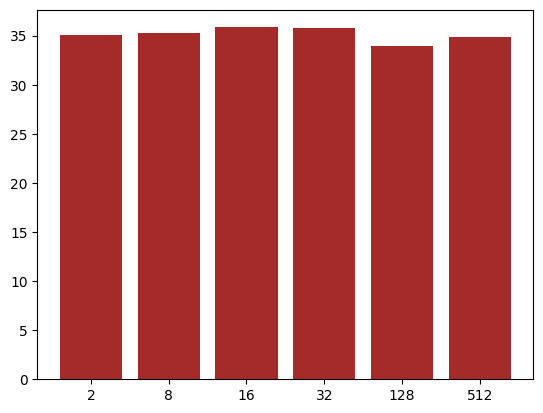

In [ ]:
plt.bar(range(len(comp)),comp,tick_label = batchsize_ls,color = "brown")

#Data Normalization

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep =";")

data = data[data["total sulfur dioxide"]<200] #removing outliers
data["boolQuality"] = np.where(data["quality"]>5,1,0)
data.drop("quality",axis = 1,inplace = True)
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  boolQuality  
0      9.4            0  
1      9.8            0  
2      9.8            0  
3      9.8            1  
4      9.4            0

In [ ]:
data_std = pd.DataFrame()
for i in data.columns:
  if i != "boolQuality":
    data_std[i] = (data[i] - np.mean(data[i]))/np.std(data[i],ddof = 1)
  else:
    data_std[i] = data[i]

data_std.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528185          0.960356    -1.391387       -0.452437  -0.244571   
1      -0.298580          1.965999    -1.391387        0.049005   0.222757   
2      -0.298580          1.295570    -1.185609       -0.165899   0.095304   
3       1.653061         -1.386143     1.489509       -0.452437  -0.265814   
4      -0.528185          0.960356    -1.391387       -0.452437  -0.244571   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.464413             -0.382415  0.556633  1.288066  -0.580034   
1             0.876758              0.654456  0.025914 -0.723425   0.127797   
2            -0.081221              0.245992  0.132058 -0.334104  -0.049161   
3             0.110375              0.434514  0.662777 -0.982972  -0.462063   
4            -0.464413             -0.382415  0.556633  1.288066  -0.580034   

    alcohol  boolQuality  
0 -0.959006            0  
1 -0.583159            0  
2 -0.583159            0  
3 -0.583159            1  
4 -0.959006            0

In [ ]:
def dataprep(data,batchsize):
  """ tranform data into tensors and batches for neural network training """

  dataT = torch.tensor(data.drop("boolQuality",axis = 1).values).float()
  labelsT = torch.tensor(data["boolQuality"].values).float()

  print(dataT.shape)
  print(labelsT.shape)

  #labelsT = labelsT[:,None]
  labelsT = labelsT.reshape(1597,1) #rearranging labels into a multidimensional array for pytorch
  print(labelsT.shape)

  data_train,data_test, labels_train, labels_test = train_test_split(dataT,labelsT,train_size = 0.9)

  train_data = TensorDataset(data_train,labels_train)
  test_data = TensorDataset(data_test,labels_test)

  #batchsize = 64
  train_loader = DataLoader(train_data,batch_size = batchsize,shuffle = True,drop_last=True )
  test_loader = DataLoader(test_data,batch_size = test_data.tensors[1].shape[0],shuffle = True )

  return train_loader,test_loader

######################################################################################################
def initialize_model():
  """ initializes a shallow network and returns model, lossfunction, optimizer"""
  model = nn.Sequential(
      nn.Linear(11,16),
      nn.ReLU(),
      nn.Linear(16,32),
      nn.ReLU(),
      nn.Linear(32,32),
      nn.ReLU(),
      nn.Linear(32,1)
  )

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

  #print(model)

  return model,lossfun,optimizer

######################################################################################################

# train model
def train(batchsize,model,lossfun,optimizer,train_loader,test_loader,numepochs):
  """ trains model for different batchsizes and returns test accuracy and compute """
  start_time = time.time() #time.process_time()

  train_accuracy = np.zeros((numepochs))
  test_accuracy = np.zeros((numepochs))

  for epochi in range(numepochs):

    batchAcc = []
    for x,y in train_loader:
      yhat = model(x)
      loss = lossfun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(torch.mean(((yhat>0)==y).float()).item()*100)


    train_accuracy[epochi] = np.mean(batchAcc)

    #test accuracy
    model.eval()

    x,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      pred = model(x)

    pred_labels = np.where(pred >0,1,0)

    test_accuracy[epochi] = torch.mean((pred_labels==y).float())*100
    model.train() # turn on training mode


  end_time = time.time()
  compute = end_time - start_time

  return train_accuracy,test_accuracy,compute

In [ ]:
batchsize = 16
numepochs = 200

#without normalization
train_loader,test_loader = dataprep(data,batchsize)
model,lossfun,optimizer = initialize_model()
train_accuracy,test_accuracy,compute = train(batchsize,model,lossfun,optimizer,train_loader,test_loader,numepochs)

#with z-score normalization
train_loader,test_loader = dataprep(data_std,batchsize)
model,lossfun,optimizer = initialize_model()
train_accuracy_std,test_accuracy_std,compute_std = train(batchsize,model,lossfun,optimizer,train_loader,test_loader,numepochs)

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])
torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


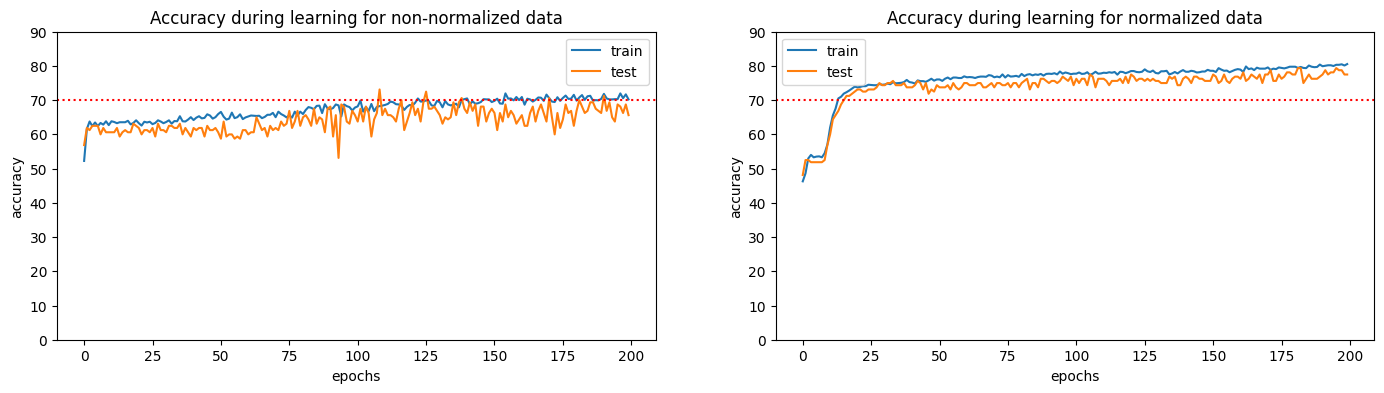

In [ ]:
fig,ax = plt.subplots(1,2, figsize = (17,4))
ax[0].plot(train_accuracy)
ax[0].plot(test_accuracy)
ax[0].set_ylim(0, 90)
ax[0].set_ylabel("accuracy")
ax[0].set_xlabel("epochs")
ax[0].set_title("Accuracy during learning for non-normalized data")
ax[0].legend(["train","test"])
ax[0].axhline(y=70, color='r', linestyle=':') # Add a dotted red line at y=70

ax[1].plot(train_accuracy_std)
ax[1].plot(test_accuracy_std)
ax[1].set_ylim(0, 90)
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("epochs")
ax[1].set_title("Accuracy during learning for normalized data")
ax[1].legend(["train","test"])
ax[1].axhline(y=70, color='r', linestyle=':') # Add a dotted red line at y=70

#Batch Normalization

In [ ]:
class model_bnorm(nn.Module):
  def __init__(self):
    super().__init__()

    #input layer
    self.input = nn.Linear(11,16)

    #hidden layers
    self.fc1 = nn.Linear(16,32)
    self.bnorm1 = nn.BatchNorm1d(16)
    self.fc2 = nn.Linear(32,20)
    self.bnorm2 = nn.BatchNorm1d(32)

    #output layer
    self.output = nn.Linear(20,1)

  def forward(self,x,doBN):
    """ doBN = boolean True (for batch norm)/False (without batch norm) """

    # input since x is already normalized in the data
    x = F.relu(self.input(x))

    if doBN:
      #hidden layer 1
      x = self.bnorm1(x) #batchnorm
      x = self.fc1(x) #weighted sum
      x = F.relu(x)  #activation function (relu)

      #hidden layer 2
      x = self.bnorm2(x) #batchnorm
      x = self.fc2(x) #weighted sum
      x = F.relu(x)  #activation function (relu)

    else:
      #hidden layer 1
      x = self.fc1(x) #weighted sum
      x = F.relu(x)  #activation function (relu)

      #hidden layer 2
      x = self.fc2(x) #weighted sum
      x = F.relu(x)  #activation function (relu)


    #output layer
    x = self.output(x)

    return x

In [ ]:
test_model = model_bnorm()
test_model.forward(torch.tensor(data.drop("boolQuality",axis =1).values).float(),True)

tensor([[-0.3175],
        [-0.0344],
        [-0.1884],
        ...,
        [-0.2312],
        [-0.1766],
        [-0.3661]], grad_fn=<AddmmBackward0>)

In [ ]:
######################################################################################################
def initialize_model():
  """ initializes a shallow network and returns model, lossfunction, optimizer"""
  model = model_bnorm()

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

  #print(model)

  return model,lossfun,optimizer

######################################################################################################

# train model
def train(batchsize,model,lossfun,optimizer,train_loader,test_loader,numepochs,doBN):
  """ trains model for different batchsizes and returns test accuracy and compute """
  start_time = time.time() #time.process_time()

  train_accuracy = np.zeros((numepochs))
  test_accuracy = np.zeros((numepochs))
  loss_train = np.zeros((numepochs))

  for epochi in range(numepochs):

    batchAcc = []
    batchLoss = []
    for x,y in train_loader:
      yhat = model(x,doBN)
      loss = lossfun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(torch.mean(((yhat>0)==y).float()).item()*100)
      batchLoss.append(loss.detach())


    train_accuracy[epochi] = np.mean(batchAcc)
    loss_train[epochi] = np.mean(batchLoss)

    #test accuracy
    model.eval()

    x,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      pred = model(x, doBN)

    pred_labels = np.where(pred >0,1,0)

    test_accuracy[epochi] = torch.mean((pred_labels==y).float())*100
    model.train() # turn on training mode


  end_time = time.time()
  compute = end_time - start_time

  return train_accuracy,test_accuracy,loss_train,compute

In [ ]:
batchsize = 32
numepochs = 1000

#with batch-normalization
doBN = True
train_loader,test_loader = dataprep(data_std,batchsize)
model,lossfun,optimizer = initialize_model()
train_accuracy_bn,test_accuracy_bn,loss_bn,compute_bn = train(batchsize,model,lossfun,optimizer,train_loader,test_loader,numepochs,doBN)

#without batch-normalization
doBN = False
train_loader,test_loader = dataprep(data_std,batchsize)
model,lossfun,optimizer = initialize_model()
train_accuracy,test_accuracy,loss,compute = train(batchsize,model,lossfun,optimizer,train_loader,test_loader,numepochs,doBN)

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])
torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


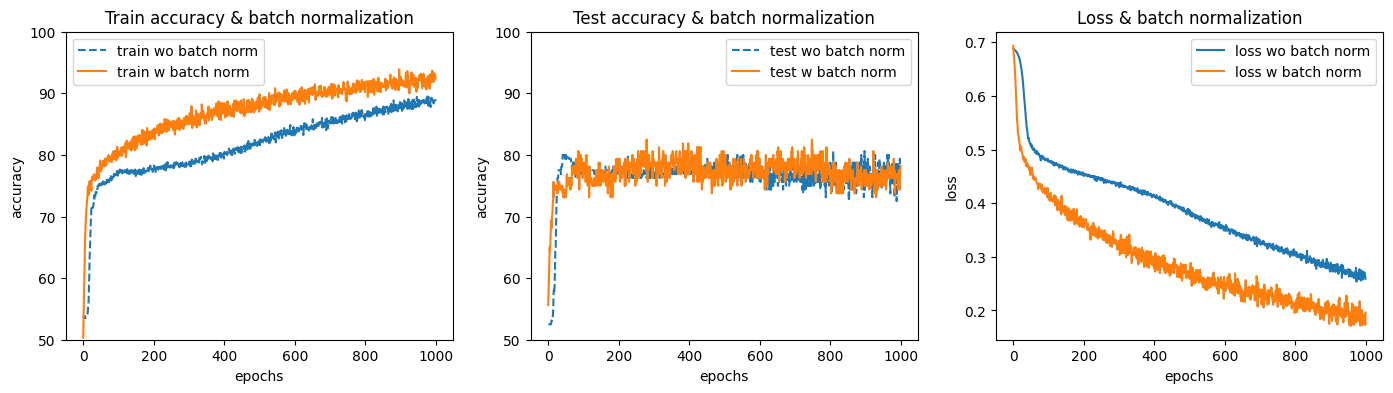

In [ ]:
fig,ax = plt.subplots(1,3, figsize = (17,4))
ax[0].plot(train_accuracy,label = "train wo batch norm",linestyle = "--")
ax[0].plot(train_accuracy_bn, label = "train w batch norm")
ax[0].set_ylim(50, 100)
ax[0].set_ylabel("accuracy")
ax[0].set_xlabel("epochs")
ax[0].set_title("Train accuracy & batch normalization")
ax[0].legend()
#ax[0].axhline(y=70, color='r', linestyle=':') # Add a dotted red line at y=70

ax[1].plot(test_accuracy, label = "test wo batch norm",linestyle = "--")
ax[1].plot(test_accuracy_bn, label = "test w batch norm")
ax[1].set_ylim(50, 100)
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("epochs")
ax[1].set_title("Test accuracy & batch normalization")
ax[1].legend()

ax[2].plot(loss,label = "loss wo batch norm")
ax[2].plot(loss_bn,label = "loss w batch norm")
ax[2].set_ylabel("loss")
ax[2].set_xlabel("epochs")
ax[2].set_title("Loss & batch normalization")
ax[2].legend()

#Activation function comparisons

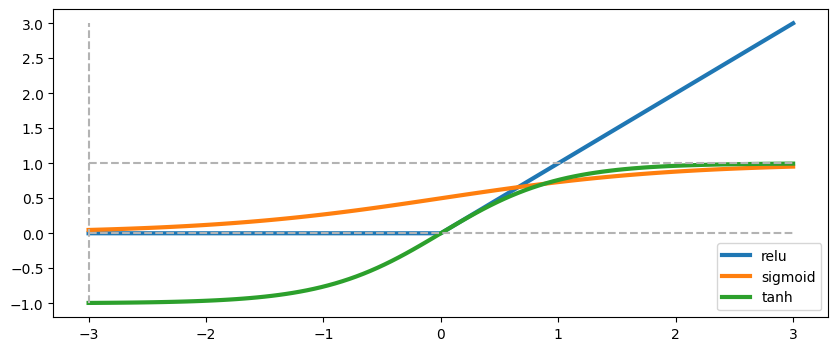

In [ ]:
x = torch.linspace(-3,3,101)

def NNoutput(actfun):
  actfun = getattr(torch,actfun)
  #actfun = getattr(torch.nn,actfun)
  return actfun(x)

activation_funs = ['relu','sigmoid','tanh']
#activation_funs = ['ReLU6','Hardshrink','LeakyReLU']

fig = plt.figure(figsize = (10,4))

for actfun in activation_funs:
  plt.plot(x,NNoutput(actfun),label = actfun,linewidth = 3)
  #plt.plot(x,NNoutput(actfun)(x),label = actfun,linewidth = 3)

dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]],[0,0],'--',color = dashlinecol)
plt.plot(x[[0,-1]],[1,1],'--',color = dashlinecol)
plt.plot(x[[0,0]],[-1,3],'--',color = dashlinecol)

plt.legend()
#https://docs.pytorch.org/docs/stable/generated/torch.nn.Hardshrink.html

In [ ]:
class model_activation_functions(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    #input layer
    self.input = nn.Linear(11,16)

    #hidden layers
    self.fc1 = nn.Linear(16,32)
    #self.bnorm1 = nn.BatchNorm1d(16)
    self.fc2 = nn.Linear(32,32)
    #self.bnorm2 = nn.BatchNorm1d(32)

    #output layer
    self.output = nn.Linear(32,1)

    #activation function
    self.actfun = actfun

  def forward(self,x):
    actfun = getattr(torch,self.actfun)
    x = actfun(self.input(x))
    x = actfun(self.fc1(x))
    x = actfun(self.fc2(x))
    x = self.output(x)

    return x

######################################################################################################
def initialize_model(actfun):
  """ initializes a shallow network and returns model, lossfunction, optimizer"""
  model = model_activation_functions(actfun)

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

  #print(model)

  return model,lossfun,optimizer

######################################################################################################

# train model
def train(batchsize,model,lossfun,optimizer,train_loader,test_loader,numepochs):
  """ trains model for different batchsizes and returns test accuracy and compute """
  start_time = time.time() #time.process_time()

  train_accuracy = np.zeros((numepochs))
  test_accuracy = np.zeros((numepochs))
  loss_train = np.zeros((numepochs))

  for epochi in range(numepochs):

    batchAcc = []
    batchLoss = []
    for x,y in train_loader:
      yhat = model(x)
      loss = lossfun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(torch.mean(((yhat>0)==y).float()).item()*100)
      batchLoss.append(loss.detach())


    train_accuracy[epochi] = np.mean(batchAcc)
    loss_train[epochi] = np.mean(batchLoss)

    #test accuracy
    model.eval()

    x,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      pred = model(x)

    pred_labels = np.where(pred >0,1,0)

    test_accuracy[epochi] = torch.mean((pred_labels==y).float())*100
    model.train() # turn on training mode


  end_time = time.time()
  compute = end_time - start_time

  return train_accuracy,test_accuracy,loss_train,compute

In [ ]:
#test the model
test_model = model_activation_functions('sigmoid')
test_model(torch.randn(10,11)).shape

torch.Size([10, 1])

In [ ]:
batchsize = 32
numepochs = 1000
activation_funs = ['relu','sigmoid','tanh']

train_loader,test_loader = dataprep(data_std,batchsize)

trainbyact = np.zeros((numepochs,len(activation_funs)))
testbyact = np.zeros((numepochs,len(activation_funs)))
lossbyact = np.zeros((numepochs,len(activation_funs)))

for i,actfun in enumerate(activation_funs):
  model,lossfun,optimizer = initialize_model(actfun)
  train_accuracy,test_accuracy,loss,compute = train(batchsize,model,lossfun,optimizer,train_loader,test_loader,numepochs)
  trainbyact[:,i] = train_accuracy
  testbyact[:,i] = test_accuracy
  lossbyact[:,i] = loss

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


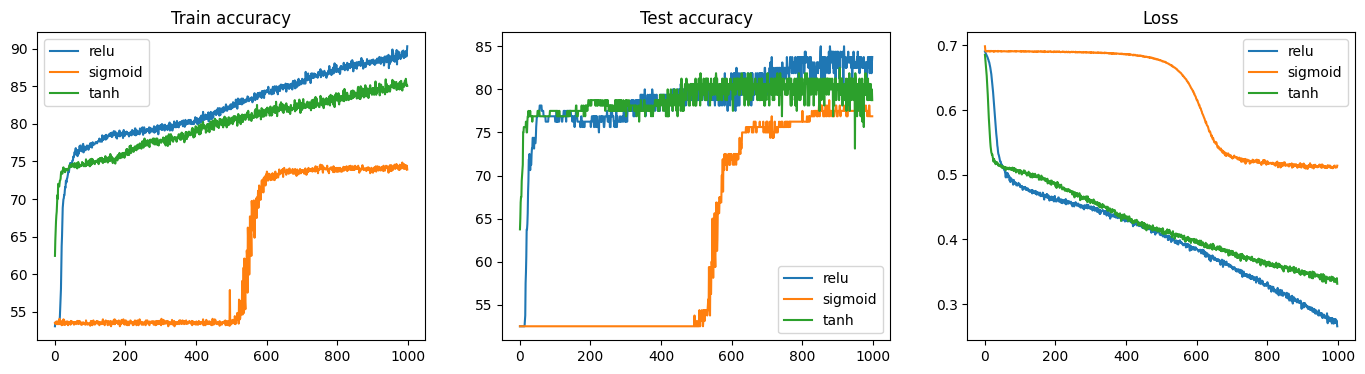

In [ ]:
fig,ax = plt.subplots(1,3,figsize = (17,4))
ax[0].plot(trainbyact)
ax[0].set_title("Train accuracy")
ax[0].legend(activation_funs)
ax[1].plot(testbyact)
ax[1].set_title("Test accuracy")
ax[1].legend(activation_funs)
ax[2].plot(lossbyact)
ax[2].set_title("Loss")
ax[2].legend(activation_funs)

In [ ]:
class model_activation_functions(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    #input layer
    self.input = nn.Linear(11,16)

    #hidden layers
    self.fc1 = nn.Linear(16,32)
    #self.bnorm1 = nn.BatchNorm1d(16)
    self.fc2 = nn.Linear(32,32)
    #self.bnorm2 = nn.BatchNorm1d(32)

    #output layer
    self.output = nn.Linear(32,1)

    #activation function
    self.actfun = actfun

  def forward(self,x):
    actfun = getattr(torch.nn,self.actfun)
    x = actfun()(self.input(x))
    x = actfun()(self.fc1(x))
    x = actfun()(self.fc2(x))
    x = self.output(x)

    return x

In [ ]:
batchsize = 64
numepochs = 1000
activation_funs = ['ReLU','ReLU6','LeakyReLU']

train_loader,test_loader = dataprep(data_std,batchsize)

trainbyact = np.zeros((numepochs,len(activation_funs)))
testbyact = np.zeros((numepochs,len(activation_funs)))
lossbyact = np.zeros((numepochs,len(activation_funs)))

for i,actfun in enumerate(activation_funs):
  model,lossfun,optimizer = initialize_model(actfun)
  train_accuracy,test_accuracy,loss,compute = train(batchsize,model,lossfun,optimizer,train_loader,test_loader,numepochs)
  trainbyact[:,i] = train_accuracy
  testbyact[:,i] = test_accuracy
  lossbyact[:,i] = loss

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


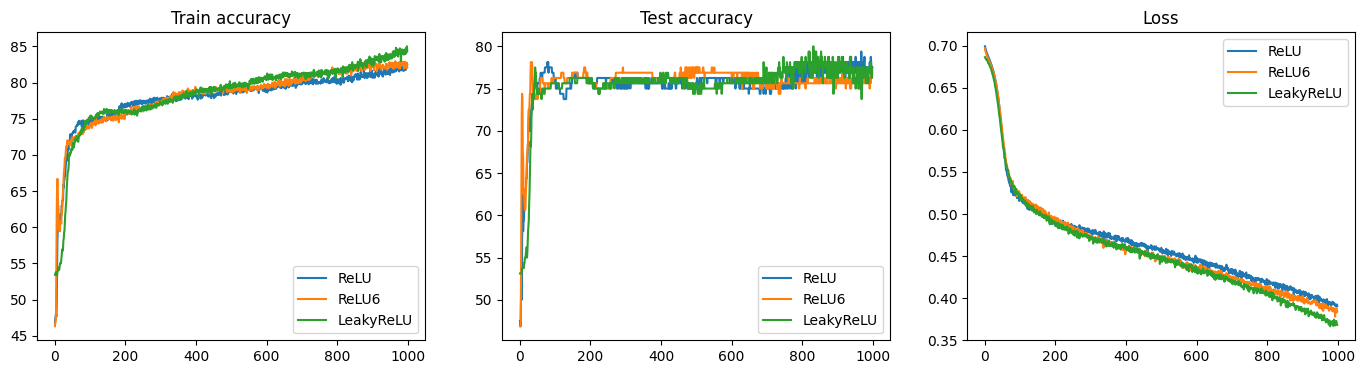

In [ ]:
fig,ax = plt.subplots(1,3,figsize = (17,4))
ax[0].plot(trainbyact)
ax[0].set_title("Train accuracy")
ax[0].legend(activation_funs)
ax[1].plot(testbyact)
ax[1].set_title("Test accuracy")
ax[1].legend(activation_funs)
ax[2].plot(lossbyact)
ax[2].set_title("Loss")
ax[2].legend(activation_funs)

#Sugar content prediction

In [ ]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

Text(0.5, 1.0, 'residual sugar')

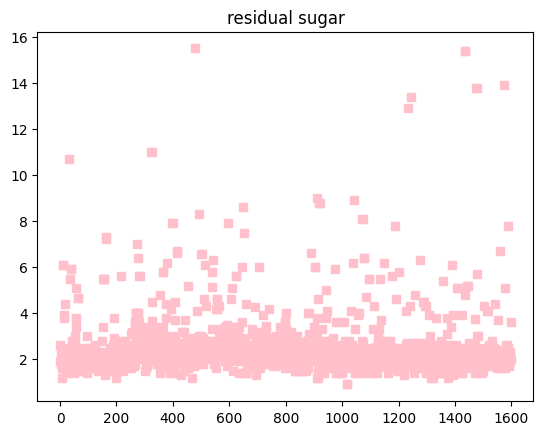

In [ ]:
plt.plot(data["residual sugar"],"s",color = "pink")
plt.title("residual sugar")

<Axes: >

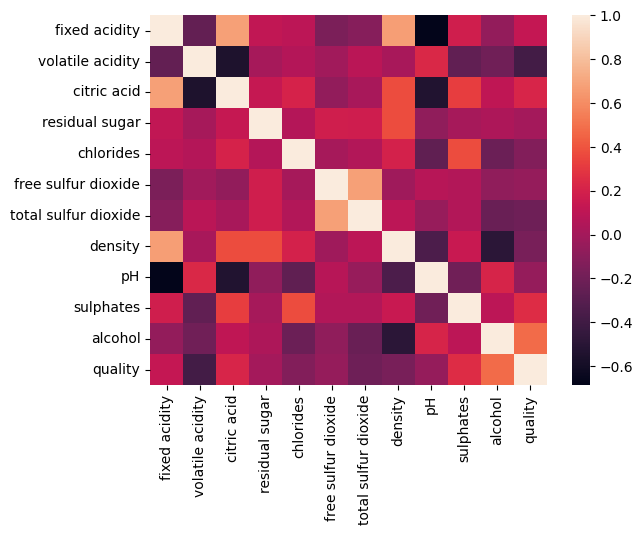

In [ ]:
sns.heatmap(data.corr())

In [ ]:
# z-score all columns except for quality
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528350          0.960657    -1.391823       -0.452579  -0.244648   
1      -0.298673          1.966614    -1.391823        0.049020   0.222827   
2      -0.298673          1.295976    -1.185980       -0.165951   0.095334   
3       1.653579         -1.386577     1.489975       -0.452579  -0.265897   
4      -0.528350          0.960657    -1.391823       -0.452579  -0.244648   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.464558             -0.382535  0.556807  1.288470  -0.580216   
1             0.877032              0.654661  0.025923 -0.723652   0.127837   
2            -0.081247              0.246069  0.132100 -0.334209  -0.049176   
3             0.110409              0.434650  0.662984 -0.983280  -0.462207   
4            -0.464558             -0.382535  0.556807  1.288470  -0.580216   

    alcohol   quality  
0 -0.959307 -0.786623  
1 -0.583341 -0.786623  
2 -0.583341 -0.786623  
3 -0.583341  0.453492  
4 -0.959307 -0.786623

In [ ]:
# convert from pandas dataframe to tensor
cols2zscore = cols2zscore.drop('residual sugar')

dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['residual sugar'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# create dataloader object
batchsize = 64
train_loader = DataLoader(train_dataDataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

Text(0.5, 1.0, 'residual  (normalized)')

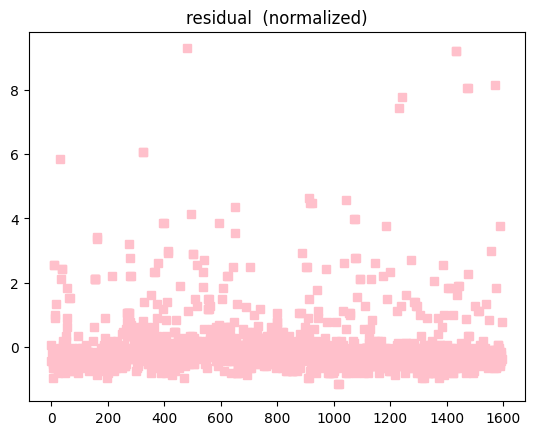

In [ ]:
plt.plot(labels,"s",color = "pink")
plt.title("residual  (normalized)")

In [ ]:
# create a class for the model
class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)
    self.fc3 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    x = F.relu( self.fc3(x) )
    return self.output(x)

In [ ]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel(winenet):

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []
  test_losses = torch.zeros(numepochs)
  corr_test = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat == y).float())).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yhat = winenet(X)
      loss = lossfun(yhat,y)
      corr_coeff = stat.pearsonr(yhat,y)[0]
    testAcc.append( 100*torch.mean(((yhat) == y).float()).item() )
    test_losses[epochi] = loss
    corr_test[epochi] = corr_coeff.item()

  # function output
  return trainAcc,testAcc,losses,test_losses,corr_test

In [ ]:
  # create and train a model
  winenet = ANNwine()
  trainAcc,testAcc,losses,test_losses,corr = trainTheModel(winenet)

In [ ]:
pred_train = winenet(train_data)
pred_test = winenet(test_data)

correlation coefficient of residual sugar predictions with training data : 0.86
correlation coefficient of residual sugar predictions with test data : 0.81


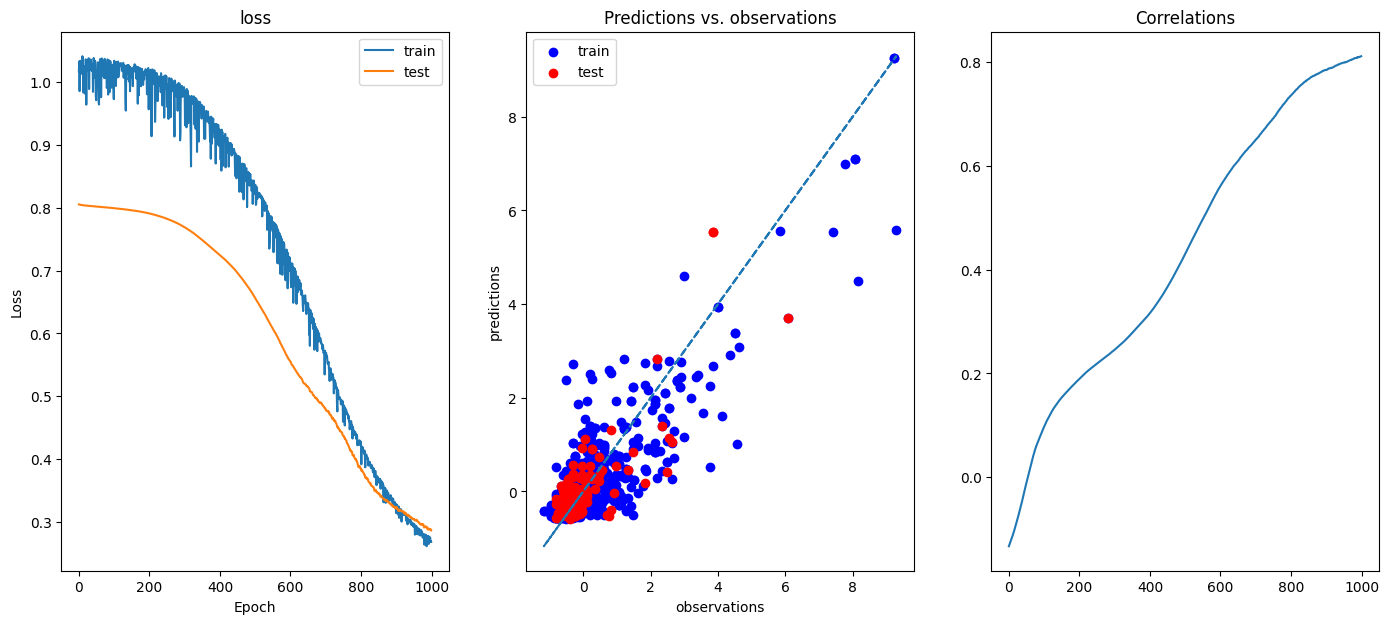

In [ ]:
# plot some results
fig,ax = plt.subplots(1,3,figsize=(17,7))

ax[0].plot(losses)
ax[0].set_title('loss')
ax[0].plot(test_losses)
ax[0].legend(["train","test"])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].scatter(train_labels,pred_train.detach(),color = "blue")
ax[1].scatter(test_labels,pred_test.detach(),color = "red")
ax[1].plot(train_labels,train_labels,linestyle = "--")
ax[1].legend(["train","test"])
ax[1].set_title('Predictions vs. observations')
ax[1].set_xlabel('observations')
ax[1].set_ylabel('predictions')

ax[2].plot(corr)
ax[2].set_title('Correlations')
print("correlation coefficient of residual sugar predictions with training data :",round(np.corrcoef(pred_train.detach().T,train_labels.T)[1,0],2))
print("correlation coefficient of residual sugar predictions with test data :",round(np.corrcoef(pred_test.detach().T,test_labels.T)[1,0],2))


# Loss functions & output layer

###BCE Loss

Text(0.5, 1.0, 'BCE Loss (numpy)')

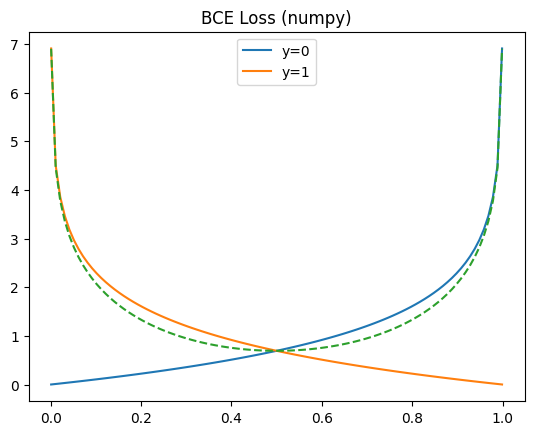

In [ ]:
y = np.linspace(0.001,0.999,100)
yh = np.flip(y)
plt.plot(y,-np.log(1-y))
plt.plot(y,-np.log(y))
plt.plot(y,-y*np.log(yh) - (1-y)*np.log(1-yh),linestyle = "--") #loss is smallest when y and yh are the same.
plt.legend(["y=0","y=1"])
plt.title("BCE Loss (numpy)")
#https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

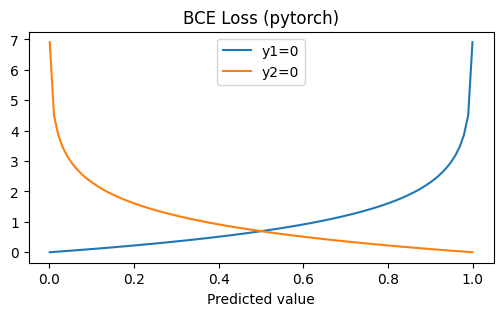

In [ ]:
#loss function : binary cross entropy
lossBCE = nn.BCELoss()
n = 100

yhat = torch.linspace(0.001,0.999,n)
y1 = torch.tensor(0.0)
y2 = torch.tensor(1.0)

L = np.zeros((n,2))
for i,yy in enumerate(yhat):
  L[i,0] = lossBCE(yy,y1)
  L[i,1] = lossBCE(yy,y2)
  #print(yy,L[i])

plt.figure(figsize = (6,3))
plt.plot(yhat,L)
plt.xlabel('Predicted value')
plt.title("BCE Loss (pytorch)")
plt.legend(["y1=0","y2=0"])

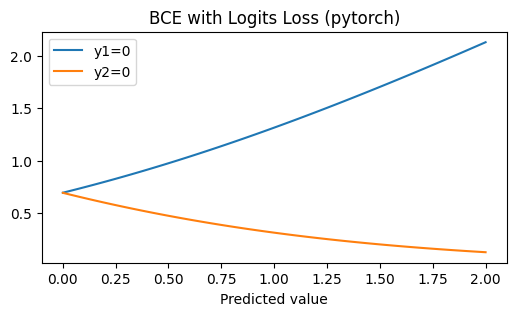

In [ ]:
#loss function : binary cross entropy
lossBCE = nn.BCEWithLogitsLoss()
n = 100

yhat = torch.linspace(0.001,2,n)
y1 = torch.tensor(0.0)
y2 = torch.tensor(1.0)

L = np.zeros((n,2))
for i,yy in enumerate(yhat):
  L[i,0] = lossBCE(yy,y1)
  L[i,1] = lossBCE(yy,y2)
  #print(yy,L[i])

plt.figure(figsize = (6,3))
plt.plot(yhat,L)
plt.xlabel('Predicted value')
plt.title("BCE with Logits Loss (pytorch)")
plt.legend(["y1=0","y2=0"])

###Categorical cross entropy loss

In [ ]:
#loss function : categorical cross entropy
loss = nn.CrossEntropyLoss() #softmax already baked into the pytorch implementation
n = 100


yhat = torch.tensor([1.0,2,3]) # 3 category values (not probabilities)
y = torch.tensor([0.0,1,2]) # 3 category values (not probabilities)

print(loss(yhat,y))
#https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

tensor(2.2228)


<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

###Kullback-Leibler Divergence

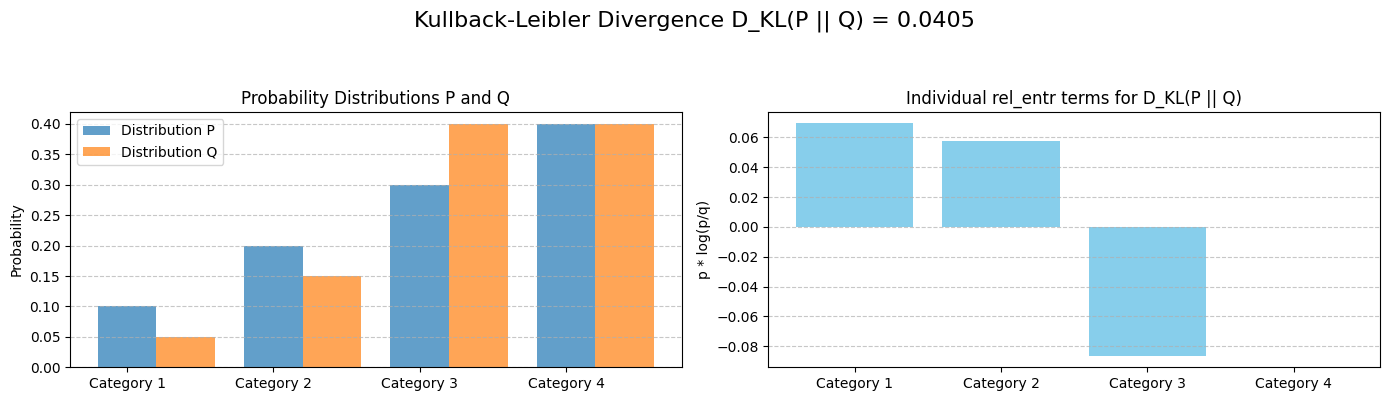

In [ ]:
#Discrete probability distributions
P = np.array([0.1, 0.2, 0.3, 0.4])
Q = np.array([0.05, 0.15, 0.4, 0.4])

#Individual relative entropy terms for D_KL(P || Q)
rel_entropy_terms_PQ = rel_entr(P, Q)

#Total KL divergence
kl_divergence_PQ = np.sum(rel_entropy_terms_PQ)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
categories = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
ax1.bar(categories, P, width=0.4, align='center', label='Distribution P', alpha=0.7)
ax1.bar(np.arange(len(categories)) + 0.4, Q, width=0.4, align='center', label='Distribution Q', alpha=0.7)
ax1.set_title('Probability Distributions P and Q')
ax1.set_ylabel('Probability')
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2.bar(categories, rel_entropy_terms_PQ, color='skyblue')
ax2.set_title('Individual rel_entr terms for D_KL(P || Q)')
ax2.set_ylabel('p * log(p/q)')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

fig.suptitle(f'Kullback-Leibler Divergence D_KL(P || Q) = {kl_divergence_PQ:.4f}', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

###Softmax Function

The **Softmax function** is a crucial component in multi-class classification problems, especially in the output layer of neural networks. It takes a vector of arbitrary real numbers (often called 'logits') and transforms them into a probability distribution. This means:

1.  Each output value will be between 0 and 1.
2.  All output values will sum up to 1.

The formula for the Softmax function for a given element $i$ in a vector $\mathbf{z}$ is:

$$ \text{Softmax}(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}} $$

Where:
*   $z_i$ is the $i$-th element of the input vector.
*   $K$ is the number of classes (elements in the vector).
*   $e$ is Euler's number (the base of the natural logarithm).

Let's visualize how this function works with a simple example.


Example single logits: [1.0, 2.0, 3.0]
Softmax probabilities: [0.09003057330846786, 0.2447284758090973, 0.6652409434318542]
Sum of probabilities: 1.0


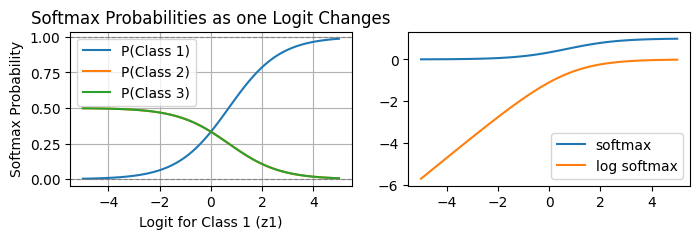

In [ ]:
#Generate some example input logits
logits_range = torch.linspace(-5, 5, 100) # Vary z1 from -5 to 5

#Create a tensor of logits where z2 and z3 are fixed
logits = torch.stack([
    logits_range,                 # z1 changes
    torch.full_like(logits_range, 0.0), # z2 is constant at 0
    torch.full_like(logits_range, 0.0)  # z3 is constant at 0
], dim=1)

#Apply softmax function
probabilities = torch.softmax(logits, dim=1)
log_softmax_manual = torch.log(probabilities)

#Plot the results
fig, ax = plt.subplots(1,2,figsize=(8, 2))
ax[0].plot(logits_range.numpy(), probabilities[:, 0].numpy(), label='P(Class 1)')
ax[0].plot(logits_range.numpy(), probabilities[:, 1].numpy(), label='P(Class 2)')
ax[0].plot(logits_range.numpy(), probabilities[:, 2].numpy(), label='P(Class 3)')

ax[1].plot(logits_range.numpy(), probabilities[:, 0].numpy(), label='softmax')
ax[1].plot(logits_range.numpy(), log_softmax_manual[:, 0].numpy(), label='log softmax')

ax[0].set_xlabel('Logit for Class 1 (z1)')
ax[0].set_ylabel('Softmax Probability')
ax[0].set_title('Softmax Probabilities as one Logit Changes')
ax[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
ax[0].axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
ax[0].legend()
ax[0].grid(True)

ax[1].legend()

single_logits = torch.tensor([1.0, 2.0, 3.0])
single_probs = torch.softmax(single_logits, dim=0)
print(f"\nExample single logits: {single_logits.tolist()}")
print(f"Softmax probabilities: {single_probs.tolist()}")
print(f"Sum of probabilities: {single_probs.sum().item()}")

###MSE Loss

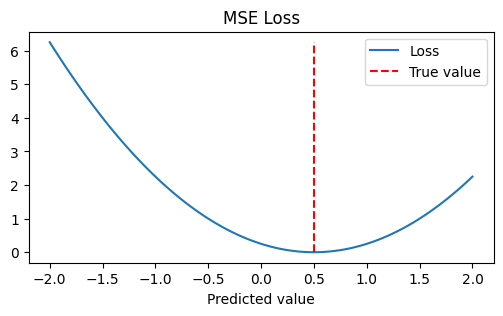

In [ ]:
#loss function
lossMSE = nn.MSELoss()
n = 100

y = torch.tensor(.5)
yhat = torch.linspace(-2,2,n)

L = np.zeros(n)
for i,yy in enumerate(yhat):
  L[i] = lossMSE(yy,y)
  #print(yy,L[i])

plt.figure(figsize = (6,3))
plt.plot(yhat,L,label = 'Loss')
plt.plot([y,y],[0,np.max(L)],'r--',label = 'True value')
plt.xlabel('Predicted value')
plt.title("MSE Loss")
plt.legend()

###Custom loss function

In [ ]:
class myLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x,y):
    loss = torch.abs(x-y) #L1
    return loss

test_loss = myLoss()
test_loss(torch.tensor(4),torch.tensor(5.3))

tensor(1.3000)

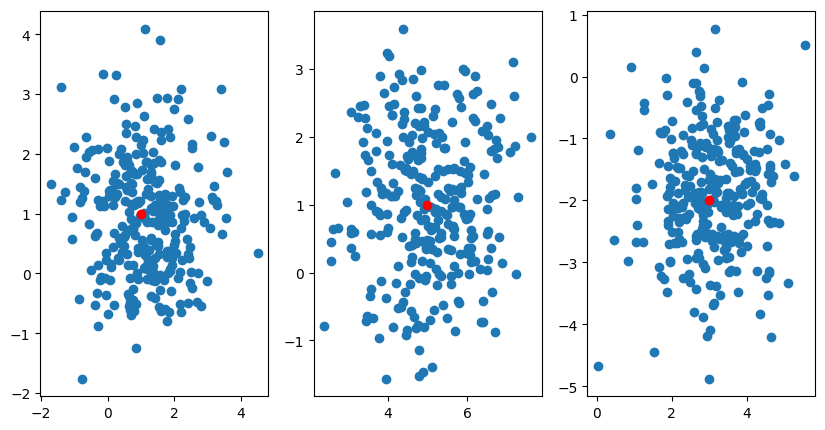

In [3]:
#create data
nPerClust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [3,-2]

a = [A[0] + np.random.randn (nPerClust)*blur,A[1] + np.random.randn (nPerClust)*blur]
b = [B[0] + np.random.randn (nPerClust)*blur,B[1] + np.random.randn (nPerClust)*blur]
c = [C[0] + np.random.randn (nPerClust)*blur,C[1] + np.random.randn (nPerClust)*blur]


## true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1)),1+np.ones((nPerClust,1))))

#concatenate into matrix
data_np = np.hstack((a,b,c)).T

##convert to a pytorch tensor
data = torch.tensor(data_np).float()
#labels = torch.tensor(labels_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

fig,ax = plt.subplots(1,3,figsize = [10,5])
ax[0].scatter(a[0],a[1])
ax[0].plot(A[0],A[1],'ro')
ax[1].scatter(b[0],b[1])
ax[1].plot(B[0],B[1],'ro')
ax[2].scatter(c[0],c[1])
ax[2].plot(C[0],C[1],'ro')

In [4]:
data_train,data_test, labels_train, labels_test = train_test_split(data,labels,train_size = 0.9)

train_data = TensorDataset(data_train,labels_train)
test_data = TensorDataset(data_test,labels_test)

batchsize = 16
train_loader = DataLoader(train_data,batch_size = batchsize,shuffle = True,drop_last=True )
test_loader = DataLoader(test_data,batch_size = test_data.tensors[1].shape[0],shuffle = True )

print(f"there are {len(train_loader)} batches, each with {batchsize} samples")

there are 50 batches, each with 16 samples


In [5]:
def model_initialize():

  class three_classification(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(2,8)
      self.fc1 = nn.Linear(8,8)
      self.output = nn.Linear(8,3)

    def forward(self,x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))

      return self.output(x)

  model = three_classification()
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

  return model,lossfun,optimizer

#test model
model,lossfun,optimizer = model_initialize()
print(model)
model(torch.rand(10,2))

three_classification(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[-0.3956, -0.4887,  0.3935],
        [-0.4020, -0.4893,  0.3893],
        [-0.3766, -0.4786,  0.3866],
        [-0.3957, -0.4817,  0.3907],
        [-0.4113, -0.4590,  0.3732],
        [-0.3754, -0.4594,  0.3860],
        [-0.4056, -0.4528,  0.3725],
        [-0.4060, -0.5059,  0.4046],
        [-0.4024, -0.4657,  0.3798],
        [-0.4078, -0.4421,  0.3693]], grad_fn=<AddmmBackward0>)

In [ ]:
def training():
  numepochs = 100
  net,lossfun,optimizer = model_initialize()
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []

  # loop over epochs
  for epochi in range(numepochs):

    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )


    trainAcc.append( np.mean(batchAcc) )


    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )


  return trainAcc,testAcc,losses,net


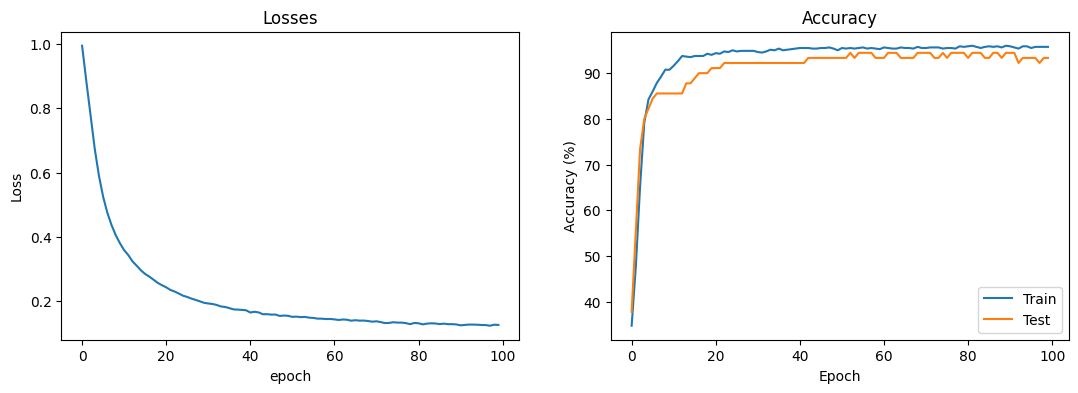

In [ ]:
trainAcc,testAcc,losses,net = training()

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()

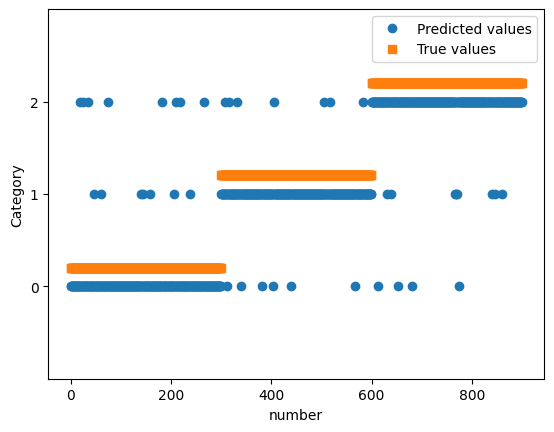

In [ ]:
# run the data through the model to get the categorical predictions
yHat = net(data)
predictions = torch.argmax(yHat,axis=1)

# and plot those against the real data
plt.plot(predictions,'o',label='Predicted values')
plt.plot(labels+.2,'s',label='True values')
plt.xlabel('number')
plt.ylabel('Category')
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.legend()
plt.show()

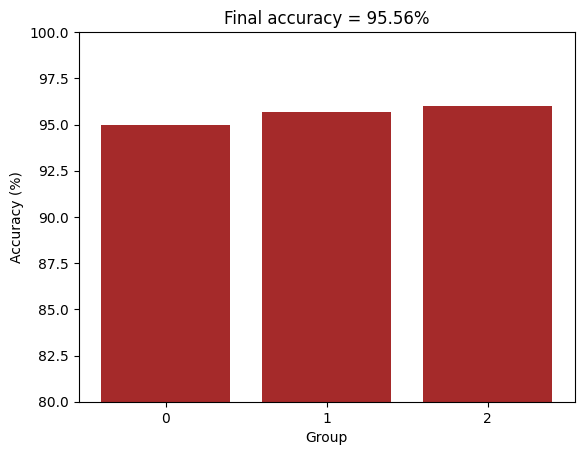

In [ ]:
# recode each prediction by accuracy
accuracy = (predictions == labels).float()

# compute overall accuracy
totalAcc = torch.mean(100*accuracy).item()

# and average by group
accuracyByGroup = np.zeros(3)
for i in range(3):
  accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])

plt.bar(range(3),accuracyByGroup,color ="brown")
plt.ylim([80,100])
plt.xticks([0,1,2])
plt.xlabel('Group')
plt.ylabel('Accuracy (%)')
plt.title(f'Final accuracy = {totalAcc:.2f}%')
plt.show()

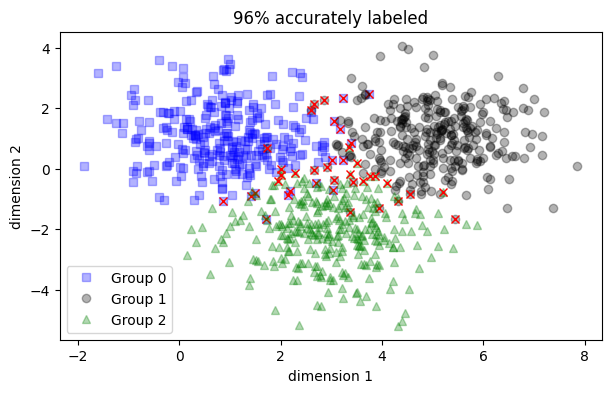

In [ ]:
# data markers
colorShapes = [ 'bs','ko','g^' ]

# show the data
fig = plt.figure(figsize=(7,4))

# plot correct and incorrect labeled data
for i in range(3):
  # plot all data points for this label
  plt.plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')

  # cross out the incorrect ones
  idxErr = (accuracy==0) & (labels==i)
  plt.plot(data[idxErr,0],data[idxErr,1],'rx')

plt.title(f'{totalAcc:.0f}% accurately labeled')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.legend()

#Optimizers

###Momentum

In [10]:
def model_initialize(momentum):

  class three_classification(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(2,8)
      self.fc1 = nn.Linear(8,8)
      self.output = nn.Linear(8,3)

    def forward(self,x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))

      return self.output(x)

  model = three_classification()
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),lr = 0.01, momentum=momentum)

  return model,lossfun,optimizer

#test model
model,lossfun,optimizer = model_initialize(0.01)
print(model)
model(torch.rand(10,2))

three_classification(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[-0.3955,  0.1323,  0.4388],
        [-0.4054,  0.1289,  0.4374],
        [-0.3838,  0.1284,  0.4521],
        [-0.4064,  0.1222,  0.4607],
        [-0.3763,  0.1303,  0.4607],
        [-0.4072,  0.1316,  0.4552],
        [-0.3879,  0.1272,  0.4501],
        [-0.4084,  0.1297,  0.4363],
        [-0.4673,  0.1262,  0.4297],
        [-0.4002,  0.1230,  0.4550]], grad_fn=<AddmmBackward0>)

In [28]:
def training(momentum):
  numepochs = 100
  net,lossfun,optimizer = model_initialize(momentum)
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []

  print(f"momentum is {momentum}")

  # loop over epochs
  for epochi in range(numepochs):

    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )


    trainAcc.append( np.mean(batchAcc) )


    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )


  return trainAcc,testAcc,losses,net,optimizer


momentum is 0
momentum is 0.5
momentum is 0.2


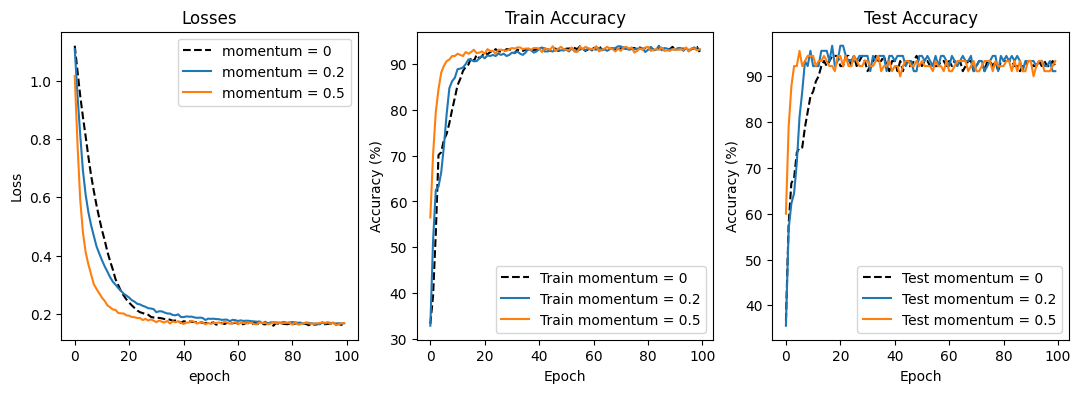

In [31]:
momentum = 0
trainAcc,testAcc,losses,net,optimizer = training(momentum)
trainAcc1,testAcc1,losses1,net1,optimizer1 = training(0.5)
trainAcc2,testAcc2,losses2,net2,optimizer2 = training(0.2)


fig,ax = plt.subplots(1,3,figsize=(13,4))

ax[0].plot(losses.detach(),label = "momentum = 0",linestyle = "--",color = "black")
ax[0].plot(losses2.detach(),label = "momentum = 0.2")
ax[0].plot(losses1.detach(),label = "momentum = 0.5")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAcc,label='Train momentum = 0',linestyle = "--",color = "black")
ax[1].plot(trainAcc2,label='Train momentum = 0.2')
ax[1].plot(trainAcc1,label='Train momentum = 0.5')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Train Accuracy')
ax[1].legend()

ax[2].plot(testAcc,label='Test momentum = 0',linestyle = "--",color = "black")
ax[2].plot(testAcc2,label='Test momentum = 0.2')
ax[2].plot(testAcc1,label='Test momentum = 0.5')
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_xlabel('Epoch')
ax[2].set_title('Test Accuracy')
ax[2].legend()

In [30]:
optimizer2

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.2
    nesterov: False
    weight_decay: 0
)

In [47]:
numepochs = 100
momentum = [0,0.2,0.5,0.7,0.99]
results = np.zeros((numepochs,len(momentum),3))

for i,im in enumerate(momentum):
  trainAcc,testAcc,losses,net,optimizer = training(im)
  results[:,i,0] = losses
  results[:,i,1] = trainAcc
  results[:,i,2] = testAcc


momentum is 0


/tmp/ipython-input-3202309351.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  results[:,i,0] = losses
/tmp/ipython-input-3202309351.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  results[:,i,2] = testAcc


momentum is 0.2
momentum is 0.5
momentum is 0.7
momentum is 0.99


Text(0.5, 1.0, 'Test Accuracy w Momentum')

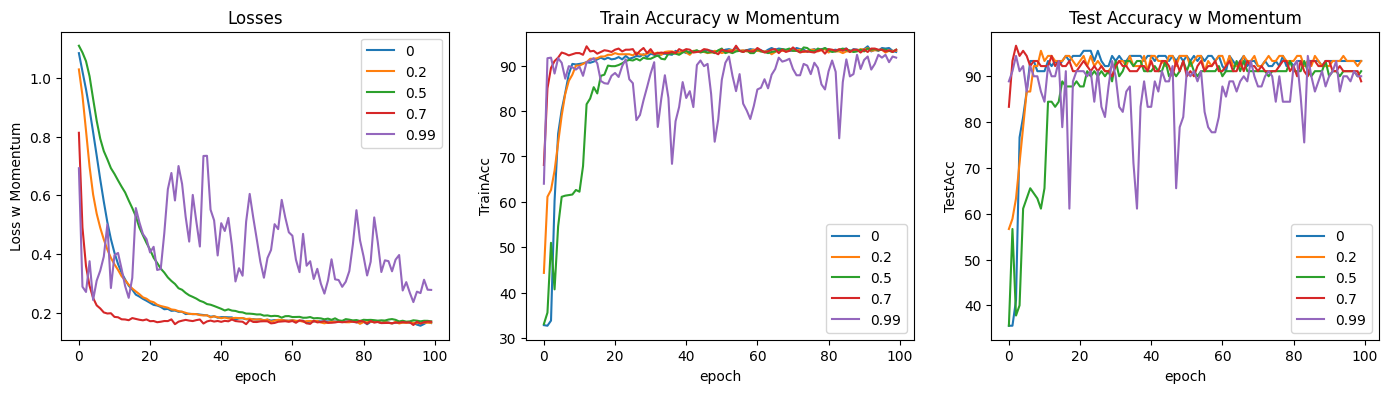

In [49]:
fig,ax = plt.subplots(1,3,figsize = (17,4))

ax[0].plot(results[:,:,0])
ax[0].legend(momentum)
ax[0].set_ylabel('Loss w Momentum')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(results[:,:,1])
ax[1].legend(momentum)
ax[1].set_ylabel('TrainAcc')
ax[1].set_xlabel('epoch')
ax[1].set_title('Train Accuracy w Momentum')

ax[2].plot(results[:,:,2])
ax[2].legend(momentum)
ax[2].set_ylabel('TestAcc')
ax[2].set_xlabel('epoch')
ax[2].set_title('Test Accuracy w Momentum')

#Summary

*  **Hyperparameter space includes** : model architecture(width & depth), activation function, loss/optimization function, cross validation sizes, mini batch sizes, learning rate, no. of iterations (epochs), dropout / regularizations , data/ weight normalization, weight initialization etc.

* **Data normalization** helps ensure that all samples are processed the same, features are treated the same and weights remain numerically stable. Having a very large feature value can cause this feature to dominate the learning, even if its not as informative. 2 main methods are Z-transform and min-max scaling.

*  **Z-transform** ensures mean is 0, standard deviation is 1. Thsi transform shifts and stretches but doesn't change shape of the original distribution. Correlation between original and transformed data is 1. Typically used for normally distributed data.

*  **Min-max scaling** scales the data from 0 to 1. Correlation with original data is 1. Commonly used for images and uniform data.

* **Batch normalization** extends the idea of normalization and applies it to each node in a neural network i.e. don't just normalize inputs, instead normalize inputs to each layer. Activation distribution characteristics(mean , variance) change as data passes through layers causing covariance shifts, vanishing or exploding gradients. Its most suited for deeper networks than shallow networks.

*  **Activation function** must be non-linear,computationally simple, avoid limited range, should avoid vanishing/exploding gradients.
  - Sigmoid function : continuous & differentiable, great for output layer, values between [0,1], not great for hidden layers because of being linear around the middle and causing vanishing gradient problems.
  - Hyperbolic tangent :continuous & differentiable, hidden or output layer, values between [-1,1]
  - ReLu : Strongly non linear, never saturates, biased average, great for hidden layers, run risk of exploding gradient problem. Batch normalization works well with relu because it protects against exploding gradients.
  - Leaky relu, relu-N, gelu etc.

* **Output Layer** For classification, output layer can include activation functions like sigmoid (binary classification) or softmax activation(multiclass classification).

* **Optimization** SGD is sensitive to outliers and using mini-batches can help reduce its sensitivity.
- Momentum : SGD with momentum takes past gradients and calculates a weighted average gradient to result in a smoother convergence. Momentum improves on gradient descent by reducing oscillatory effects and acting as an accelerator for optimization problem solving.






